<a href="https://colab.research.google.com/github/katearb/Data-Science-Notebooks/blob/master/3_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/katearb/files/blob/main/recipes.zip?raw=true

In [ ]:
!unzip /content/recipes.zip?raw=true

In [ ]:
!cd /content && git clone --branch=stable https://github.com/bigartm/bigartm.git

In [ ]:
!cd /content/bigartm && mkdir build

In [ ]:
!cd /content/bigartm/build && cmake -DPYTHON=python3 ..

In [ ]:
!cd /content/bigartm/build && make

In [ ]:
!cd /content/bigartm/build && sudo make install

In [ ]:
!export ARTM_SHARED_LIBRARY=/usr/local/lib/libartm.so

In [ ]:
!cd /content/bigartm/python && python setup.py install

### restart runtime

In [ ]:
!pip install pyLDAvis

In [ ]:
!pip uninstall numpy
!pip uninstall pandas

!pip install --user numpy
!pip install --user  pandas

In [ ]:
import artm
artm.version()

'0.10.0'

In [ ]:
import json
import random
import pandas as pd
import itertools
from functools import reduce
from tqdm import tqdm

import logging
import pyLDAvis
from wordcloud import WordCloud, STOPWORDS

import numpy as np
from numpy import array

import matplotlib.colors as mcolors
from matplotlib import pyplot as plt

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

from gensim import utils, models, corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import gensim.parsing.preprocessing as gsp


import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Preparation

In [ ]:
# download the data
data = pd.read_csv('/content/recipes.csv')

In [ ]:
data.head()

,tags,title,ingredients,time,steps,category,Калорийность,Белки,Жиры,Углеводы
0,Пошаговые рецепты/Заготовки/Грузинская кухня,Капуста по‑грузински,13411:Вода\n13410:Сахар\n13421:Соль\n14585:Укс...,30 минут + 5 суток,"0. Смешать воду, сахар и соль, довести до кипе...",zagotovki,91 ккал,"2,7 грамм","0,2 грамм","18,6 грамм"
1,Пошаговые рецепты/Заготовки/Веганская еда,Арбузный мед,14287:Арбуз,5 часов,"0. Арбуз помыть, обсушить и разрезать на четыр...",zagotovki,350 ккал,"8,4 грамм","1,4 грамм","81,2 грамм"
2,Пошаговые рецепты/Заготовки/Русская кухня/Соле...,Маринованные опята,14584:Опята\n13422:Уксус\n13421:Соль\n13460:Ла...,40 минут + 1 сутки,0. Промытые опята бросить в кипящую воду и вар...,zagotovki,36 ккал,"2,4 грамм","1,4 грамм","4,6 грамм"
3,Пошаговые рецепты/Заготовки/Русская кухня/Соле...,Соленые огурцы по бабушкиному рецепту,15137:Огурцы\n13421:Соль\n14786:Листья черной ...,30 минут + 20 суток,0. Огурцы лучше брать небольшие и плотные. Дли...,zagotovki,142 ккал,"7,4 грамм",1 грамм,"24,9 грамм"
4,Пошаговые рецепты/Заготовки/Варенье,Клубничное варенье с черным перцем,13494:Клубника\n13410:Сахар\n13427:Лимон\n1373...,1 час,0. Вымыть клубнику под проточной водой. Лучше ...,zagotovki,4460 ккал,12 грамм,"4,7 грамм","1083,9 грамм"


In [ ]:
# keep needed columns
data['text'] = data['title'] + data['steps']
data = data[['tags', 'text']]

In [ ]:
data.head()

,tags,text
0,Пошаговые рецепты/Заготовки/Грузинская кухня,"Капуста по‑грузински0. Смешать воду, сахар и с..."
1,Пошаговые рецепты/Заготовки/Веганская еда,"Арбузный мед0. Арбуз помыть, обсушить и разрез..."
2,Пошаговые рецепты/Заготовки/Русская кухня/Соле...,Маринованные опята0. Промытые опята бросить в ...
3,Пошаговые рецепты/Заготовки/Русская кухня/Соле...,Соленые огурцы по бабушкиному рецепту0. Огурцы...
4,Пошаговые рецепты/Заготовки/Варенье,Клубничное варенье с черным перцем0. Вымыть кл...


## Exploration

In [ ]:
# explore most frequent words
def get_sorted_freqs(all_texts):
  freq_dict = {}
  for word in all_texts:
    freq_dict[word] = freq_dict.get(word, 0) + 1
  freq_list = [(k, v) for k, v in freq_dict.items()]
  return sorted(freq_list, key=lambda x: x[1], reverse=True)

In [ ]:
all_texts = ''
for doc in data['text']: all_texts += str(doc)
all_texts = all_texts.split()

In [ ]:
sorted_freqs = get_sorted_freqs(all_texts)
out_of_stopwords = [word[0].lower() for word in sorted_freq[:100] if word[0].lower() not in russian_stopwords]

In [ ]:
out_of_stopwords[:50]

['масло',
 'тесто',
 'духовку',
 'лук',
 'обжарить',
 'огне',
 'сковороде',
 '5',
 'сверху',
 'маслом',
 'смешать',
 'примерно',
 'течение',
 'слегка',
 'смесь',
 'форму',
 '180',
 'посыпать',
 '10',
 'нарезанный',
 'сковороду',
 'масло,',
 'миске',
 'перец',
 '\n4.',
 'смешайте',
 'кастрюлю',
 'разогрейте',
 'поставить',
 'около',
 'сливочное',
 'соус',
 '30',
 'огонь',
 '3',
 'среднем',
 'взбить',
 'смешать',
 'сок',
 'мясо',
 'перемешать',
 'чеснок',
 'выложите',
 'сахар',
 'масла',
 'воду',
 'ложки',
 'залить',
 'добавляем',
 'соль']

In [ ]:
# some extra stopwords from the top list which I cosidered not topic specific.
extra_stopwords = [
 'сверху',
 'примерно',
 'течение',
 'слегка',
 'посыпать',
 'смешайте',
 'поставить',
 'около',
 'среднем',
 'смешать',
 'перемешать',
 'выложите',
 'ложки',
 'добавляем']

### Data Preprocessing

In [ ]:
class Cleaner(BaseEstimator, TransformerMixin):
  def __init__(self, filters):
    self.filters = filters

  def fit(self, X: pd.Series):
    return self

  def _transform_doc(self, s: str):
    s = str(s).lower() # lower case for all words
    s = utils.to_unicode(s)
    for f in self.filters:
        s = f(s)
    return s

  def transform(self, X: pd.Series()):
    clean_X = [self._transform_doc(doc) for doc in tqdm(X)]
    return pd.Series(clean_X)

def calculate_roc_auc(y_true, y_pred_proba):
  score = roc_auc_score(y_true, y_pred_proba)
  print('ROC-AUC score:', score)
  return score

def stem_text(text):
  stemmer = SnowballStemmer("russian") 
  return ' '.join([stemmer.stem(word) for word in text.split()])

def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in russian_stopwords])

russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(extra_stopwords)

In [ ]:
def prepare_corpus(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, doc_term_matrix

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=num_topics, 
                         id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, 
                                        dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_coherence_graph(doc_clean,start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,
                                                            doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [ ]:
# data preparation pipeline
filters = [
           gsp.strip_tags,  # remove tags 
           gsp.strip_punctuation,  # remove punctuation
           gsp.strip_multiple_whitespaces,  # standarized the spaces 
           gsp.strip_numeric,
           remove_stopwords,  # stop words  
           gsp.strip_short,  # delete words with len < 3
           stem_text  # stemming 
          ]

cleaner = Cleaner(filters)
data['text'] = cleaner.fit_transform(data['text'])

In [ ]:
# tokenize the data
data_tokenized = [*map(lambda x: x.split(), data['text'])]

In [ ]:
# prepare the data for the models
dictionary, doc_term_matrix = prepare_corpus(data_tokenized)

### Tags exploration

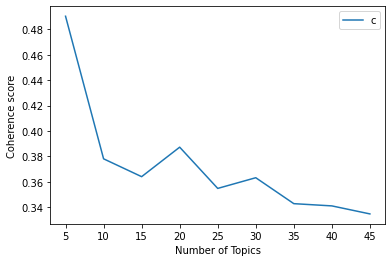

In [ ]:
# plot coherence-number_of_classes plot
start,stop,step = 5, 50, 5
plot_coherence_graph(data_tokenized, start, stop, step)

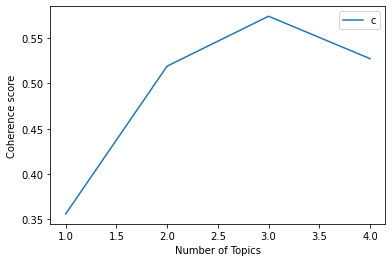

In [ ]:
# plot coherence-number_of_classes plot more detailed
start,stop,step = 1, 5, 1
plot_coherence_graph(data_tokenized, start, stop, step)

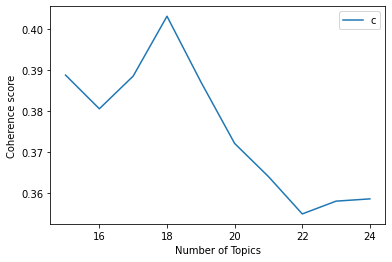

In [ ]:
# plot coherence-number_of_classes plot more detailed
start,stop,step = 15, 25, 1
plot_coherence_graph(data_tokenized, start, stop, step)

In [ ]:
tags = data['tags']
tags = reduce(lambda x,y: x + y, [*map(lambda x: x.split('/'), tags)])

In [ ]:
pd.Series(tags).value_counts()

Выпечка и десерты     9440
Основные блюда        9313
Европейская кухня     8726
Закуски               5241
Русская кухня         4393
                      ... 
Расстегаи                1
Тестовая группа          1
Крымская кухня           1
Солянка с колбасой       1
Сингапурская кухня       1
Length: 427, dtype: int64

### definition of number of topics.
In the original dataset, 427 unique topics were found which are able to coocur in one text sample. These topics are not homogenous: some describe type of food (e.g. "Выпечка и десерты", "Закуски"), some define belonging the dish to some national cuisines (e.g. "Крымская кухня", "Сингапурская кухня"). Therefore, these given topics cannot be the basis for number of classes considered. 
Coherence score also says less is better and considers the optimal number of topics equal to 5. However, after some experiments I found out that such a small number leads to the situation when top-important words for topics are nearly the same, i.e. lack of diversity.
So, I considered to choose number of topics equal to 18 as at this point a peak is observed on the graph and results seem reasonable under such a condition.

# LSA

In [ ]:
lsa = LsiModel(doc_term_matrix, num_topics=18, id2word=dictionary) 

In [ ]:
#lsa.print_topics(num_topics=18, num_words=10)

# LDA

In [ ]:
lda = LdaModel(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=18, 
                random_state=100,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)

In [ ]:
#lda.print_topics(num_topics=18, num_words=10)

# ARTM

In [ ]:
with open('artm_data.txt', 'w') as f:
  for sample in data.iterrows():
    f.write(f'{sample[1][1]} |class {tags[1][0]}')
    f.write('\n')

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='artm_data.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')

In [ ]:
artm_dictionary = artm.Dictionary()
artm_dictionary.gather(data_path='my_collection_batches')

In [ ]:
artm_model = artm.ARTM(num_topics=18, dictionary=artm_dictionary)

In [ ]:
artm_model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=15))

coherence_score = artm.TopTokensScore(
                            name='TopTokensCoherenceScore',
                            class_id='@default_class',
                            num_tokens=10,
                            dictionary=artm_dictionary)
artm_model.scores.add(coherence_score)

In [ ]:
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

# Comparison

In [ ]:
def calculate_uci(model, texts, dictionary):
  uci_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
  uci = uci_model.get_coherence()

  return uci

def calculate_u_mass(model, texts, dictionary):
  u_mass_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="u_mass")
  u_mass = u_mass_model.get_coherence()

  return u_mass

In [ ]:
mycolors = list(mcolors.TABLEAU_COLORS.items())
mycolors.extend([('tab:indigo', '#4b0082'),
                ('tab:corral', '#ff7f50'),
                ('tab:light_pink', '#fadadd'),
                ('tab:cornflowerblue', '#6495ed'),
                ('tab:black', '#000000'),
                ('tab:crayola', '#7ba05b'),
                ('tab:taubmans', '#acb78e'),
                ('tab:dark_aquamarin', '#116062'),
                ('tab:unplesant', '#606211'),
                ('tab:eggplant', '#990066')])
mycolors = [color for name, color in mycolors]

In [ ]:
def draw_wordcloud(topics, num_topics=18, mycolors=mycolors):

  cloud = WordCloud(background_color='white', width=2500, height=1800,
                    max_words=10, colormap='tab20',
                    color_func=lambda *args, **kwargs: mycolors[i],
                    prefer_horizontal=1.0)

  fig, axes = plt.subplots(3, 6, figsize=(20, 6), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')


  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.show()

In [ ]:
def draw_tsne(topic_weights, model_name, num_topics=18, mycolors=mycolors):
  topic_weights_df = pd.DataFrame(topic_weights).fillna(0).values

  # Keep the well separated points
  topic_weights_df = topic_weights_df[np.amax(topic_weights_df, axis=1) > 0.35]
  topic_num = np.argmax(topic_weights_df, axis=1)

  tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
  tsne = tsne_model.fit_transform(topic_weights_df)

  # plot clusters
  output_notebook()
  mycolors = np.array(mycolors)
  plot = figure(title=f"t-SNE Clustering of {num_topics} {model_name} Topics", 
                plot_width=900, plot_height=700)
  plot.scatter(x=tsne[:,0], y=tsne[:,1], color=mycolors[topic_num])
  show(plot)

### calculate scores

In [ ]:
# Compute UCI Score
uci_lsa = calculate_uci(lsa, data_tokenized, dictionary)
uci_lda = calculate_uci(lda, data_tokenized, dictionary)
coherence_artm = artm_model.score_tracker['TopTokensCoherenceScore'].average_coherence

In [ ]:
# Compute UMass Score using 
u_mass_lsa = calculate_u_mass(lsa, data_tokenized, dictionary)
u_mass_lda = calculate_u_mass(lda, data_tokenized, dictionary)

In [ ]:
results = pd.DataFrame([['LSA', uci_lsa, u_mass_lsa], ['LDA', uci_lda, u_mass_lda]], 
                       columns=['Models', 'UCI', 'UMass'])

In [ ]:
results

,Models,UCI,UMass
0,LSA,0.396070,-1.843275
1,LDA,0.448587,-4.483399


For better performance:
*   UCI -> 1

*   UMass -> 0


LSA shows better UMass score, but UCI is better for LDA.

In [ ]:
coherence_artm

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

artm broken..(

### word clouds & t-SNE

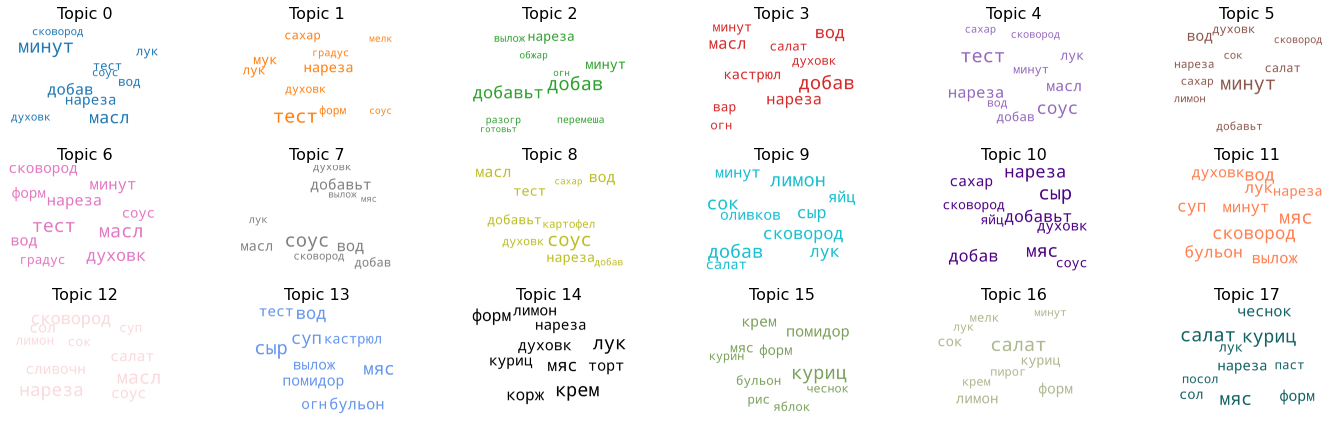

In [ ]:
lsa_topics = lsa.show_topics(num_topics=18, formatted=False)
lsa_topics = [(num, list(map(lambda x: (x[0], abs(x[1])), topic))) for num, topic in lsa_topics]
draw_wordcloud(lsa_topics)

At first sight, it is hard to follow the theme of any topic: some words are repeated in many topics, e.g. "духовка" is presented in 10 topics, "лук" in 8, "тесто" in 5 etc. It is almost impossible to name any of the topics.

In [ ]:
lsa_topic_weights = [[w for i, w in row_list] for i, row_list in enumerate(lsa[doc_term_matrix])]
draw_tsne(lsa_topic_weights, 'LSA')

[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.358017
[t-SNE] KL divergence after 1000 iterations: 3.295337


T-SNE vesualization confirms my conclusion on word clouds: the topics are not consistent and are often overlaped. The majority of the texts belong to one most common topic 0.

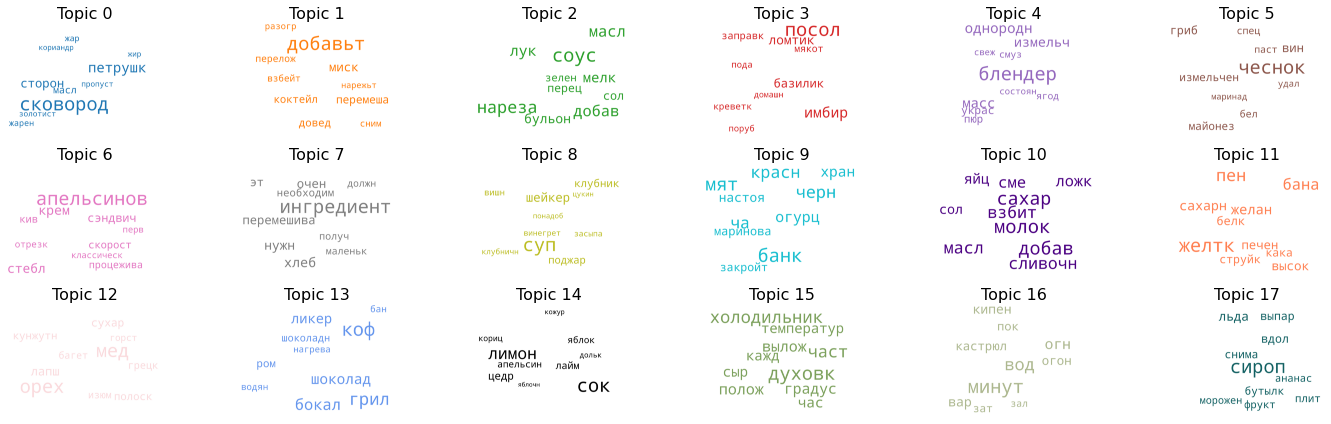

In [ ]:
lda_topics = lda.show_topics(num_topics=20, formatted=False)
draw_wordcloud(lda_topics)

LDA seems to manage its work better: it could find there topics for vegetables and fruits(14), sweets-related(11) and dairy-related(10).

In [ ]:
lda_topic_weights = [[w for i, w in row_list[0]] for i, row_list in enumerate(lda[doc_term_matrix])]

In [ ]:
draw_tsne(lda_topic_weights, 'LDA')

[t-SNE] KL divergence after 1000 iterations: 1.470456


LDA model shows a better performance, clusters are well-separatable and consistent. However, after filtering there are a few samples left, so the confidence of the model is low. The green topic 2 is the largest and contains many most common terms.

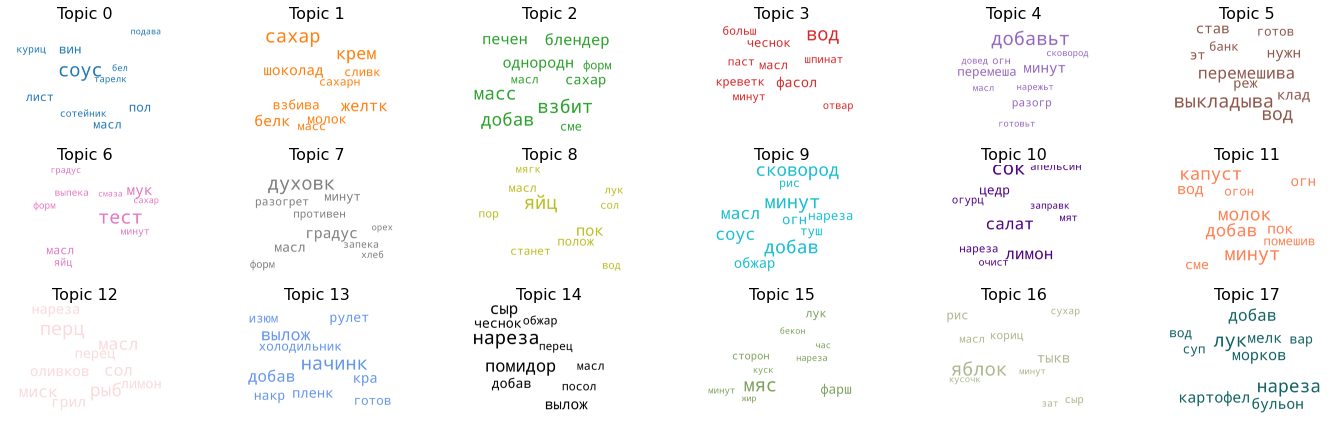

In [ ]:
artm_scores = artm_model.score_tracker['TopTokensScore'].last_weights
artm_topics = []
for topic_name in artm_model.topic_names:
  words = artm_model.score_tracker['TopTokensScore'].last_tokens[topic_name]
  scores = artm_model.score_tracker['TopTokensScore'].last_weights[topic_name]
  artm_topics.append((topic_name, list(zip(words, scores))))

draw_wordcloud(artm_topics)

ARTM did the work better than previous models: its topics are more consistent, e.g. soup-related (17), meat-related(15), bakery-related (6), sweets-related(1, 2).

In [ ]:
test_theta_matrix = artm_model.transform(batch_vectorizer=batch_vectorizer).T

In [ ]:
artm_topic_weights = [row[1].values for row in test_theta_matrix.iterrows()]

In [ ]:
draw_tsne(artm_topic_weights, 'ARTM')

[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.780838
[t-SNE] KL divergence after 1000 iterations: 2.067052


On the ARTM graph, there are many numerous and well-formed dense clusters. All are nearly same sized.

#### Conclusion
Based on the metrics and visualization, the ARTM model showed the best results on every test compared to two other models which I can rank in the  following way: the 2nd place - LDA, the 3rd - LSA.